In [1]:
## Librerias
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import warnings
import numpy as np
import psycopg2
import os

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from psycopg2 import OperationalError
from tqdm.auto import tqdm
from shapely.geometry import Point,LineString
from pydruid.client import *
from pydruid.db import connect
from sklearn.neighbors import BallTree
from dotenv import load_dotenv
warnings.filterwarnings('ignore')

c:\Users\jctor\anaconda3\envs\idv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## cargando vias de colombia
vias_gdf = gpd.read_file('../Data/vias_colombia.gpkg')
vias_gdf['fclass_reclass'].unique() 

<StringArray>
['Pavimentada', 'Sin pavimentar']
Length: 2, dtype: str

In [3]:
### Mat Machine
# cargar información de un vehiculo desde un csv

vehicles_df = pd.read_csv('../Data/LOGAN_EQUIRRENT.csv')

# filtrar por columna valid = True
vehicles_df = vehicles_df[vehicles_df['valid'] == True]

# renombrar columna fixtime como time_stamp_event
vehicles_df = vehicles_df.rename(columns={'fixtime': 'time_stamp_event'})

# extraer de la columna attributes el valor de ignition y crear una nueva columna llamada ignition
vehicles_df['ignition_status'] = vehicles_df['attributes'].str.extract(r'"ignition":\s*(true|false)').replace({'true': True, 'false': False})

vehicles_df['plate'] = 'LOGAN_EQUIRRENT'
vehicles_df['imei'] = '123123123'
vehicles_df['company_name'] = 'EQUIRRENT'
vehicles_df['manufacturer_name'] = 'Teltonika'
vehicles_df['reference_name'] = 'FMC920'

# crear gdf de vehicles_df
gdf_plate_druid = gpd.GeoDataFrame(vehicles_df, geometry=gpd.points_from_xy(vehicles_df.longitude, vehicles_df.latitude), crs='EPSG:4326')

In [4]:
# Definir el CRS
CRS_9377 = "EPSG:9377"

def optimized_map_matching_with_progress(points_gdf, lines_gdf, max_distance, sample_interval=20, k_neighbors=5):
    """
    Map matching optimizado para grandes datasets con barra de progreso
    
    Args:
        points_gdf: GeoDataFrame con puntos
        lines_gdf: GeoDataFrame con líneas  
        max_distance: Distancia máxima para matching (metros)
        sample_interval: Intervalo en metros para muestrear las líneas
        k_neighbors: Número de vecinos más cercanos a considerar
    """
    
    print("🔧 INICIANDO MAP MATCHING CON CRS 9377")
    print(f"Puntos a procesar: {len(points_gdf):,}")
    print(f"Líneas disponibles: {len(lines_gdf):,}")
    
    # Hacer copias para no modificar los originales
    points = points_gdf.copy()
    lines = lines_gdf.copy()
    
    # Definir columnas específicas a preservar
    columns_to_preserve = [
        'time_stamp_event', 'plate', 'imei', 'company_name',
        'manufacturer_name', 'reference_name', 'event', 'longitude', 'latitude','ignition_status'
    ]
        
    print("\n CONVIRTIENDO A CRS 9377...")
    if points.crs != CRS_9377:
        points = points.to_crs(CRS_9377)
    if lines.crs != CRS_9377:
        lines = lines.to_crs(CRS_9377)
    print("Conversión CRS completada")
    
    print("\nAPLICANDO FILTRO ESPACIAL...")
    points_buffer = points.copy()
    points_buffer.geometry = points_buffer.geometry.buffer(max_distance * 2)
    
    candidate_pairs = gpd.sjoin(points_buffer, lines, how='inner', predicate='intersects')
    print(f"Filtro espacial completado: {len(candidate_pairs):,} pares candidatos encontrados")
    
    if len(candidate_pairs) == 0:
        print("No se encontraron candidatos. Revisa los datos o aumenta max_distance")
        return gpd.GeoDataFrame(columns=['point_id', 'line_id', 'distance', 'geometry'] + columns_to_preserve, crs=CRS_9377)
    
    print("\nMUESTREANDO PUNTOS EN LÍNEAS...")
    line_samples = []
    line_indices = []
    line_geometries = []
    
    unique_line_ids = candidate_pairs.index_right.unique()
    
    for line_idx in tqdm(unique_line_ids, desc="Muestreando líneas"):
        line = lines.loc[line_idx]
        geom = line.geometry
        
        if geom.length > 0:
            num_samples = max(2, int(geom.length / sample_interval))
            distances = np.linspace(0, geom.length, num_samples)
            
            for dist in distances:
                sample_point = geom.interpolate(dist)
                line_samples.append([sample_point.x, sample_point.y])
                line_indices.append(line_idx)
                line_geometries.append(geom)
    
    print(f"Muestreo completado: {len(line_samples):,} puntos de referencia")
    
    if not line_samples:
        raise ValueError("No se pudieron extraer puntos de las líneas")
    
    # 4. Crear índice espacial con BallTree
    print("\nCONSTRUYENDO ÍNDICE ESPACIAL...")
    line_points_array = np.array(line_samples)
    tree = BallTree(line_points_array, metric='euclidean')
    print("Índice espacial construido")
    
    print("\nREALIZANDO MAP MATCHING...")
    results = []
    points_with_candidates = candidate_pairs.index.unique()
    
    for point_idx in tqdm(points_with_candidates, desc="Procesando puntos"):
        point_row = points.loc[point_idx]
        point_geom = point_row.geometry
        point_coord = [[point_geom.x, point_geom.y]]
        
        # Buscar k vecinos más cercanos
        distances, indices = tree.query(point_coord, k=min(k_neighbors, len(line_samples)), return_distance=True)
        
        best_match = None
        best_distance = float('inf')
        
        for dist, idx in zip(distances[0], indices[0]):
            if dist <= max_distance:
                line_idx = line_indices[idx]
                line_geom = line_geometries[idx]
                
                # Calcular punto exacto más cercano en la línea
                closest_point = line_geom.interpolate(line_geom.project(point_geom))
                actual_distance = point_geom.distance(closest_point)
                
                if actual_distance <= max_distance and actual_distance < best_distance:
                    best_distance = actual_distance
                    
                    best_match = {
                        'point_id': point_idx,
                        'line_id': line_idx,
                        'distance': actual_distance,
                        'geometry': closest_point,
                        'original_point_geometry': point_geom
                    }
                    
                    # Añadir todas las columnas específicas a preservar
                    for col in columns_to_preserve:
                        if col in point_row:
                            best_match[col] = point_row[col]
        
        if best_match:
            results.append(best_match)
    
    # 6. Crear GeoDataFrame con resultados
    
    if not results:
        print("No se encontraron matches dentro de la distancia especificada")
        return gpd.GeoDataFrame(columns=['point_id', 'line_id', 'distance', 'geometry', 'original_point_geometry','ignition_status'] + columns_to_preserve, crs=CRS_9377)
    
    results_df = pd.DataFrame(results)
    
    if 'geometry' in results_df.columns and len(results_df) > 0:
        result_gdf = gpd.GeoDataFrame(
            results_df, 
            geometry='geometry',
            crs=CRS_9377
        )
    else:
        print("No hay geometrías válidas en los resultados")
        return gpd.GeoDataFrame(columns=['point_id', 'line_id', 'distance', 'geometry', 'original_point_geometry','ignition_status'] + columns_to_preserve, crs=CRS_9377)
    
    # Mostrar estadísticas finales
    print("\nESTADÍSTICAS FINALES:")
    print(f"   • Puntos procesados: {len(points):,}")
    print(f"   • Matches encontrados: {len(result_gdf):,}")
    print(f"   • Tasa de éxito: {len(result_gdf)/len(points)*100:.1f}%")
    
    if len(result_gdf) > 0:
        print(f"   • Distancia promedio: {result_gdf['distance'].mean():.2f} m")
        print(f"   • Distancia mínima: {result_gdf['distance'].min():.2f} m")
        print(f"   • Distancia máxima: {result_gdf['distance'].max():.2f} m")
        print(f"   • Puntos sin match: {len(points) - len(result_gdf):,}")
    
    print("MAP MATCHING COMPLETADO")
    return result_gdf

In [5]:
def run_map_matching(points_gdf, lines_gdf, max_distance):
    """
    Función principal para ejecutar el map matching
    """
    try:
        resultado = optimized_map_matching_with_progress(
            points_gdf, 
            lines_gdf, 
            max_distance=max_distance
        )
        return resultado
    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()
        return None

In [6]:
def preparar_datos(points_gdf, lines_gdf):
    """
    Prepara los datos para el map matching
    """
    print("VERIFICANDO DATOS...")
    # Verificar que hay geometrías válidas
    points_valid = points_gdf[points_gdf.geometry.is_valid & points_gdf.geometry.notna()]
    lines_valid = lines_gdf[lines_gdf.geometry.is_valid & lines_gdf.geometry.notna()]   
    return points_valid, lines_valid

In [7]:
### PipeLine matmachine
if __name__ == "__main__":
    # Preparar datos
    puntos_preparados, lineas_preparadas = preparar_datos(gdf_plate_druid, vias_gdf)
    
    # Ejecutar map matching
    resultado = run_map_matching(puntos_preparados, lineas_preparadas, max_distance=100)
    
    if resultado is not None and len(resultado) > 0:        
        # Mostrar primeras filas
        print("\n📋 MUESTRA DE RESULTADOS:")
        display(resultado.head(3))
    else:
        print("\n❌ No se pudieron generar resultados")

VERIFICANDO DATOS...
🔧 INICIANDO MAP MATCHING CON CRS 9377
Puntos a procesar: 133,050
Líneas disponibles: 758,913

 CONVIRTIENDO A CRS 9377...
Conversión CRS completada

APLICANDO FILTRO ESPACIAL...
Filtro espacial completado: 3,669,557 pares candidatos encontrados

MUESTREANDO PUNTOS EN LÍNEAS...


Muestreando líneas: 100%|██████████| 27745/27745 [00:13<00:00, 2089.44it/s]


Muestreo completado: 293,741 puntos de referencia

CONSTRUYENDO ÍNDICE ESPACIAL...
Índice espacial construido

REALIZANDO MAP MATCHING...


Procesando puntos: 100%|██████████| 133041/133041 [01:31<00:00, 1446.54it/s]



ESTADÍSTICAS FINALES:
   • Puntos procesados: 133,050
   • Matches encontrados: 132,776
   • Tasa de éxito: 99.8%
   • Distancia promedio: 3.96 m
   • Distancia mínima: 0.00 m
   • Distancia máxima: 99.97 m
   • Puntos sin match: 274
MAP MATCHING COMPLETADO

📋 MUESTRA DE RESULTADOS:


,point_id,line_id,distance,geometry,original_point_geometry,time_stamp_event,plate,imei,company_name,manufacturer_name,reference_name,longitude,latitude,ignition_status
0,0,205478,27.745948,POINT (4608116.407 1942352.582),POINT (4608130.458264729 1942376.5068083224),2025-09-08 22:15:35,LOGAN_EQUIRRENT,123123123,EQUIRRENT,Teltonika,FMC920,-76.527248,3.471858,False
1,1,205478,27.745948,POINT (4608116.407 1942352.582),POINT (4608130.458264729 1942376.5068083224),2025-09-08 23:15:35,LOGAN_EQUIRRENT,123123123,EQUIRRENT,Teltonika,FMC920,-76.527248,3.471858,False
2,6,205478,27.745948,POINT (4608116.407 1942352.582),POINT (4608130.458264729 1942376.5068083224),2025-09-09 04:15:35,LOGAN_EQUIRRENT,123123123,EQUIRRENT,Teltonika,FMC920,-76.527248,3.471858,False


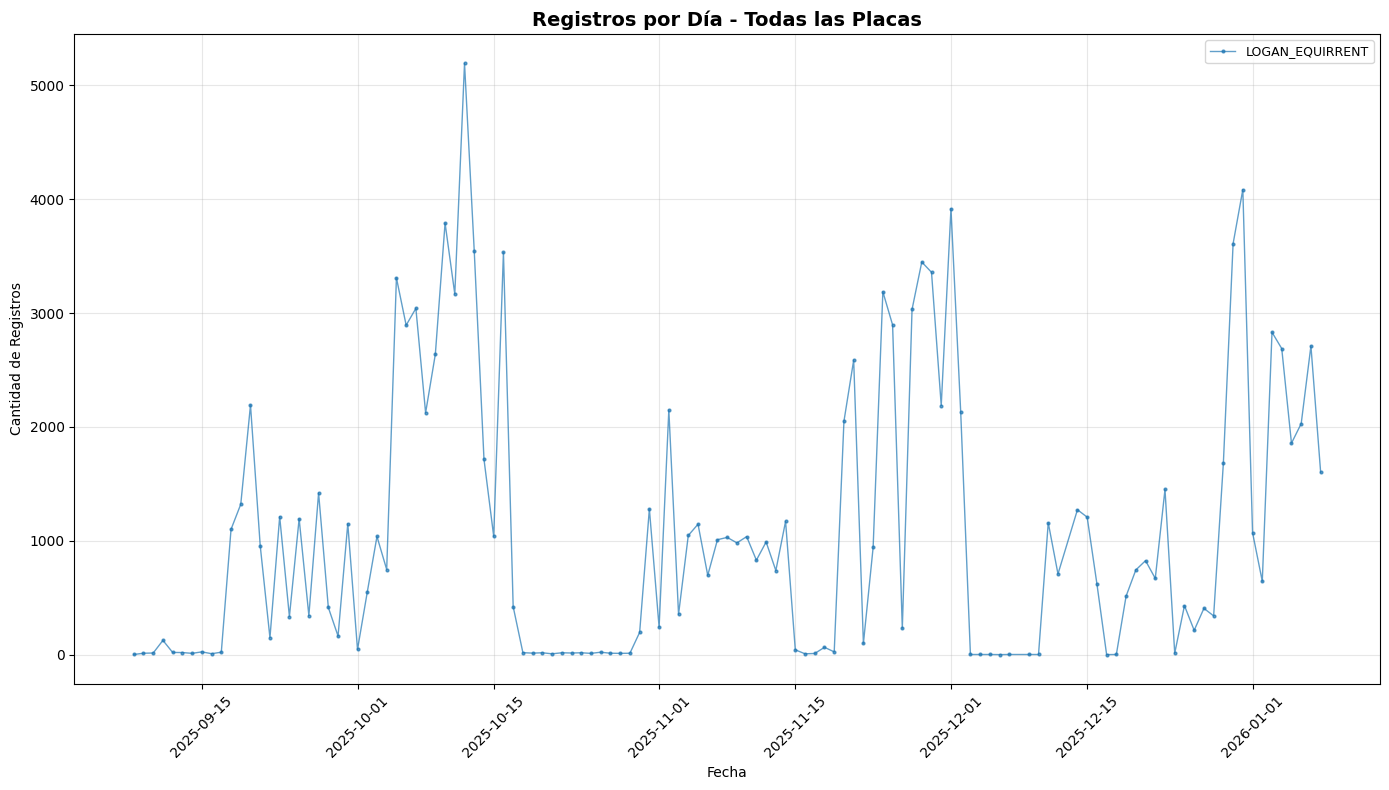


Total de placas únicas: 1

Top 10 placas con más registros:
          Placa  Total_Registros     Primer_Registro     Último_Registro
LOGAN_EQUIRRENT           131710 2025-09-08 22:15:35 2026-01-08 03:38:43


In [8]:
try:
    

    # 1. Manejar columna de timestamp
    timestamp_col = None
    for col_name in ['timestamp', 'time_stamp_event']:
        if col_name in gdf_plate_druid.columns:
            timestamp_col = col_name
            break
    
    if timestamp_col is None:
        raise ValueError("No se encontró columna de timestamp. Buscando columnas con 'time' o 'date'...")
    
    # Convertir a datetime si no lo es
    if not pd.api.types.is_datetime64_any_dtype(gdf_plate_druid[timestamp_col]):
        gdf_plate_druid['timestamp'] = pd.to_datetime(gdf_plate_druid[timestamp_col], errors='coerce')
        gdf_plate_druid = gdf_plate_druid.dropna(subset=['timestamp'])
    else:
        gdf_plate_druid['timestamp'] = gdf_plate_druid[timestamp_col]
    
    # 2. Manejar columna de placa
    plate_col = None
    for col_name in ['plate', 'placa', 'license_plate']:
        if col_name in gdf_plate_druid.columns:
            plate_col = col_name
            break
    
    if plate_col is None:
        # Si no hay columna de placa, crear una dummy
        print("⚠️ No se encontró columna de placa. Usando valor único.")
        gdf_plate_druid['plate'] = 'UNICA'
    else:
        gdf_plate_druid['plate'] = gdf_plate_druid[plate_col]
    
    # 3. Crear columna de fecha
    gdf_plate_druid['fecha'] = gdf_plate_druid['timestamp'].dt.date
    
    # 4. Crear tabla pivot y gráfico
    pivot_table = gdf_plate_druid.groupby(['fecha', 'plate']).size().unstack(fill_value=0)
    
    if not pivot_table.empty:
        plt.figure(figsize=(14, 8))
        
        for placa in pivot_table.columns:
            plt.plot(pivot_table.index, pivot_table[placa], 
                    marker='o', markersize=2, linewidth=1, alpha=0.7, 
                    label=str(placa))
        
        plt.title('Registros por Día - Todas las Placas', fontsize=14, fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Cantidad de Registros')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        if len(pivot_table.columns) > 10:
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
        else:
            plt.legend(loc='best', fontsize=9)
            plt.tight_layout()
        
        plt.show()
    
    # 5. Estadísticas
    stats_por_placa = gdf_plate_druid.groupby('plate')['timestamp'].agg(['count', 'min', 'max']).reset_index()
    stats_por_placa.columns = ['Placa', 'Total_Registros', 'Primer_Registro', 'Último_Registro']
    stats_por_placa = stats_por_placa.sort_values('Total_Registros', ascending=False)
    
    print(f"\nTotal de placas únicas: {len(stats_por_placa)}")
    print("\nTop 10 placas con más registros:")
    print(stats_por_placa.head(10).to_string(index=False))
    
except Exception as e:
    print(f"Error: {e}")
    print("\nColumnas disponibles en el DataFrame:")
    print(list(gdf_plate_druid.columns))

In [9]:
# Funcion para creación de rutas por viaje y segmentación por tipo de vía
gdf_puntos = resultado.copy()

def crear_rutas_por_viaje(gdf_puntos, gdf_vias, buffer_distancia=50, crs_proyectado='EPSG:9377', verbose=True):
    """
    Crea rutas segmentadas por tipo de vía a partir de puntos de mapmatching
    usando ignition_status para identificar viajes
    
    Parameters:
    -----------
    gdf_puntos : GeoDataFrame
        Puntos de GPS con columna 'ignition_status'
    gdf_vias : GeoDataFrame
        Vías con columna 'fclass_reclass'
    buffer_distancia : int
        Distancia en metros para el buffer de búsqueda (default: 50m)
    crs_proyectado : str
        CRS proyectado para operaciones espaciales (default: EPSG:9377)
    verbose : bool
        Si True, muestra información detallada del proceso
    """
    
    def log(msg):
        if verbose:
            print(msg)
    
    log("="*70)
    log("INICIANDO CREACIÓN DE RUTAS POR VIAJE")
    log("="*70)
        
    # 1. VERIFICAR Y REPARAR GEOMETRÍAS
    puntos_invalidos = (~gdf_puntos.geometry.is_valid).sum()
    vias_invalidas = (~gdf_vias.geometry.is_valid).sum()
    
    if puntos_invalidos > 0:
        gdf_puntos = gdf_puntos[gdf_puntos.geometry.is_valid].copy()
    
    if vias_invalidas > 0:
        gdf_vias = gdf_vias[gdf_vias.geometry.is_valid].copy()
    
    # 2. CONVERTIR A CRS PROYECTADO (METROS) - CRÍTICO
    
    # Guardar CRS original para devolver resultados
    crs_original = gdf_puntos.crs
    
    # Función para convertir a CRS proyectado
    def convertir_a_proyectado(gdf, nombre, crs_objetivo):
        if gdf.crs is None:
            gdf = gdf.set_crs('EPSG:4326', allow_override=True)
            gdf = gdf.to_crs(crs_objetivo)
        elif str(gdf.crs) != crs_objetivo:
            log(f"   {nombre}: de {gdf.crs} a {crs_objetivo}")
            try:
                gdf = gdf.to_crs(crs_objetivo)
            except Exception as e:
                # Intentar convertir a WGS84 primero
                gdf = gdf.to_crs('EPSG:4326')
                gdf = gdf.to_crs(crs_objetivo)
        else:
            None
        return gdf
    
    # Convertir ambos datasets
    gdf_puntos_proj = convertir_a_proyectado(gdf_puntos, "Puntos", crs_proyectado)
    gdf_vias_proj = convertir_a_proyectado(gdf_vias, "Vías", crs_proyectado)
    
    # 3. VERIFICAR SUPERPOSICIÓN DE ÁREAS
    bbox_puntos = gdf_puntos_proj.total_bounds
    bbox_vias = gdf_vias_proj.total_bounds
        
    # Calcular superposición
    superposicion_x = (bbox_puntos[0] <= bbox_vias[2]) and (bbox_puntos[2] >= bbox_vias[0])
    superposicion_y = (bbox_puntos[1] <= bbox_vias[3]) and (bbox_puntos[3] >= bbox_vias[1])
    
    if not (superposicion_x and superposicion_y):
        
        # Calcular distancia entre bounding boxes
        centro_puntos = gdf_puntos_proj.unary_union.centroid
        centro_vias = gdf_vias_proj.unary_union.centroid
        distancia_centros = centro_puntos.distance(centro_vias)
                
        if distancia_centros > 10000:
            # Aumentar buffer automáticamente
            nuevo_buffer = min(5000, int(distancia_centros * 0.1))
            buffer_distancia = nuevo_buffer
    else:
        None

    # 4. VERIFICAR IGNITION_STATUS
    if 'ignition_status' not in gdf_puntos_proj.columns:
        log(" ERROR: No se encontró la columna 'ignition_status'")
        log(f" Columnas disponibles: {gdf_puntos_proj.columns.tolist()}")
        return gpd.GeoDataFrame()
    
    # 5. PROCESAR TIMESTAMPS
    if not pd.api.types.is_datetime64_any_dtype(gdf_puntos_proj['time_stamp_event']):
        try:
            gdf_puntos_proj['time_stamp_event'] = pd.to_datetime(gdf_puntos_proj['time_stamp_event'])
        except Exception as e:
            log(f" Error convirtiendo timestamps: {e}")
            return gpd.GeoDataFrame()
    else:
        None

    # 6. CONVERTIR IGNITION_STATUS A BOOLEANO
    if gdf_puntos_proj['ignition_status'].dtype == 'object':
        gdf_puntos_proj['ignition_bool'] = gdf_puntos_proj['ignition_status'].apply(
            lambda x: str(x).lower().strip() in ['true', '1', 'yes', 'on', 'encendido', 'si', 't', 'sí', 'encendida', 'verdadero']
        )
    else:
        gdf_puntos_proj['ignition_bool'] = gdf_puntos_proj['ignition_status'].astype(bool)

    # 7. IDENTIFICAR VIAJES USANDO IGNITION_STATUS
    log("\n IDENTIFICANDO VIAJES:")
    gdf_puntos_proj = gdf_puntos_proj.sort_values(['imei','plate','time_stamp_event'])
    gdf_puntos_proj['viaje_id'] = None
    
    viaje_actual = 0
    viajes_identificados = 0

    for vehiculo in gdf_puntos_proj[['imei','plate']].drop_duplicates().values:
        puntos_vehiculo = gdf_puntos_proj[
            (gdf_puntos_proj['imei'] == vehiculo[0]) & (gdf_puntos_proj['plate'] == vehiculo[1])
        ].copy()

        en_viaje = False
        puntos_viaje_actual = []
        
        for i in range(len(puntos_vehiculo)):
            punto_actual = puntos_vehiculo.iloc[i]
            idx_actual = puntos_vehiculo.index[i]
            
            if i == 0:
                if punto_actual['ignition_bool']:
                    en_viaje = True
                    puntos_viaje_actual = [idx_actual]
                    viaje_actual += 1
                    gdf_puntos_proj.loc[idx_actual, 'viaje_id'] = f"{vehiculo}_viaje_{viaje_actual}"
                continue
            
            punto_anterior = puntos_vehiculo.iloc[i-1]
            
            # Detectar cambios en ignición
            if not punto_anterior['ignition_bool'] and punto_actual['ignition_bool']:
                # Encendido -> inicio de viaje
                en_viaje = True
                puntos_viaje_actual = [idx_actual]
                viaje_actual += 1
                gdf_puntos_proj.loc[idx_actual, 'viaje_id'] = f"{vehiculo}_viaje_{viaje_actual}"
                
            elif punto_anterior['ignition_bool'] and not punto_actual['ignition_bool']:
                # Apagado -> fin de viaje
                if en_viaje and puntos_viaje_actual:
                    puntos_viaje_actual.append(idx_actual)
                    en_viaje = False
                    gdf_puntos_proj.loc[puntos_viaje_actual, 'viaje_id'] = f"{vehiculo}_viaje_{viaje_actual}"
                    puntos_viaje_actual = []
                    viajes_identificados += 1
                    
            elif en_viaje:
                # Continuación del viaje
                puntos_viaje_actual.append(idx_actual)
                gdf_puntos_proj.loc[idx_actual, 'viaje_id'] = f"{vehiculo}_viaje_{viaje_actual}"
    
    # Filtrar puntos con viajes identificados
    gdf_viajes = gdf_puntos_proj[gdf_puntos_proj['viaje_id'].notna()].copy()
    log(f"   ✅ Viajes identificados: {gdf_viajes['viaje_id'].nunique()}")
    log(f"   ✅ Puntos en viajes: {len(gdf_viajes):,}")
    
    if len(gdf_viajes) == 0:
        log("❌ No se identificaron viajes completos")
        return gpd.GeoDataFrame()
    
    # 8. JOIN ESPACIAL MEJORADO CON BUFFER Y SPATIAL INDEX
    log(f"\n REALIZANDO CRUCE ESPACIAL (buffer={buffer_distancia}m):")
    
    # Crear spatial index para vías
    log(" Creando spatial index para vías...")
    vias_sindex = gdf_vias_proj.sindex
    
    # Preparar listas para resultados
    fclass_results = []
    distancia_results = []
    indices = []
    
    # Procesar puntos con progreso
    log(f" Procesando {len(gdf_viajes):,} puntos...")
    
    for idx, punto in tqdm(gdf_viajes.iterrows(), total=len(gdf_viajes), disable=not verbose):
        # Crear buffer alrededor del punto
        buffer_punto = punto.geometry.buffer(buffer_distancia)
        
        # Usar spatial index para encontrar vías candidatas
        posibles_vias_idx = list(vias_sindex.query(buffer_punto))
        
        if posibles_vias_idx:
            # Obtener vías candidatas
            vias_candidatas = gdf_vias_proj.iloc[posibles_vias_idx]
            
            # Filtrar solo las que realmente intersectan
            mask_intersect = vias_candidatas.intersects(buffer_punto)
            vias_intersectan = vias_candidatas[mask_intersect]
            
            if len(vias_intersectan) > 0:
                # Calcular distancia exacta a cada vía
                distancias = vias_intersectan.geometry.distance(punto.geometry)
                
                # Encontrar la vía más cercana
                idx_min = distancias.idxmin()
                via_mas_cercana = vias_intersectan.loc[idx_min]
                
                fclass_results.append(via_mas_cercana['fclass_reclass'])
                distancia_results.append(distancias.min())
            else:
                fclass_results.append('Desconocido')
                distancia_results.append(np.inf)
        else:
            fclass_results.append('Desconocido')
            distancia_results.append(np.inf)
        
        indices.append(idx)
    
    # Agregar resultados al GeoDataFrame
    gdf_viajes = gdf_viajes.copy()
    resultados_df = pd.DataFrame({
        'fclass_reclass': fclass_results,
        'distancia_a_via': distancia_results
    }, index=indices)
    
    gdf_viajes = gdf_viajes.join(resultados_df)
    
    # Llenar NaN con 'Desconocido'
    gdf_viajes['fclass_reclass'] = gdf_viajes['fclass_reclass'].fillna('Desconocido')
    
    # Estadísticas del join
    log(f"\n📊 RESULTADOS DEL JOIN ESPACIAL:")
    log(f"   - Puntos procesados: {len(gdf_viajes):,}")
    
    puntos_con_via = gdf_viajes[gdf_viajes['fclass_reclass'] != 'Desconocido']
    puntos_sin_via = gdf_viajes[gdf_viajes['fclass_reclass'] == 'Desconocido']
    
    log(f"   - Puntos con vía asignada: {len(puntos_con_via):,} ({len(puntos_con_via)/len(gdf_viajes)*100:.1f}%)")
    log(f"   - Puntos sin vía asignada: {len(puntos_sin_via):,} ({len(puntos_sin_via)/len(gdf_viajes)*100:.1f}%)")
    
    if len(puntos_con_via) > 0:
        # Estadísticas de distancia
        distancias_validas = puntos_con_via['distancia_a_via']
        
        # Distribución de tipos de vía
        log(f"\n   📈 DISTRIBUCIÓN DE TIPOS DE VÍA:")
        distribucion = puntos_con_via['fclass_reclass'].value_counts().head(10)
        for tipo, count in distribucion.items():
            porcentaje = (count / len(puntos_con_via)) * 100
            log(f"      {tipo}: {count:,} puntos ({porcentaje:.1f}%)")
    else:
        log("   ⚠️  No se encontraron coincidencias espaciales")
        # Intentar con buffer más grande
        if buffer_distancia < 500:
            log(f"   ⚙️  Considera aumentar buffer_distancia (> {buffer_distancia}m)")
    
    # Si no hay suficientes puntos con vía asignada, mostrar warning
    if len(puntos_con_via) / len(gdf_viajes) < 0.3:
        log("   ⚠️  ADVERTENCIA: Menos del 30% de puntos tienen vía asignada")
    
    # 9. CREAR SEGMENTOS DE RUTA
    log("\n CREANDO SEGMENTOS DE RUTA...")
    segmentos_rutas = []
    
    # Agrupar por viaje
    viajes_grupos = gdf_viajes.groupby(['imei', 'viaje_id'])
    log(f"   Procesando {len(viajes_grupos.groups)} viajes...")
    
    for (vehiculo, viaje_id), grupo in viajes_grupos:
        grupo = grupo.sort_values('time_stamp_event')
        
        if len(grupo) < 2:
            continue
        
        # Información del viaje
        primer_punto = grupo.iloc[0]
        ultimo_punto = grupo.iloc[-1]
        
        try:
            duracion_viaje = (ultimo_punto['time_stamp_event'] - primer_punto['time_stamp_event']).total_seconds()
        except:
            duracion_viaje = 0
        
        # Inicializar primer segmento
        segmento_actual = {
            'fclass_reclass': grupo.iloc[0]['fclass_reclass'],
            'puntos': [grupo.iloc[0]['geometry']],
            'timestamps': [grupo.iloc[0]['time_stamp_event']],
            'indices': [grupo.index[0]]
        }
        
        for i in range(1, len(grupo)):
            punto_actual = grupo.iloc[i]
            fclass_actual = punto_actual['fclass_reclass']
            
            # Si cambia el tipo de vía, crear nuevo segmento
            if fclass_actual != segmento_actual['fclass_reclass']:
                # Crear segmento si hay al menos 2 puntos
                if len(segmento_actual['puntos']) >= 2:
                    try:
                        segmento_linea = LineString(segmento_actual['puntos'])
                        duracion_segmento = (segmento_actual['timestamps'][-1] - segmento_actual['timestamps'][0]).total_seconds()
                        
                        segmentos_rutas.append({
                            'imei': vehiculo,
                            'viaje_id': viaje_id,
                            'fclass_reclass': segmento_actual['fclass_reclass'],
                            'inicio_viaje': primer_punto['time_stamp_event'],
                            'fin_viaje': ultimo_punto['time_stamp_event'],
                            'duracion_viaje_minutos': duracion_viaje / 60,
                            'inicio_segmento': segmento_actual['timestamps'][0],
                            'fin_segmento': segmento_actual['timestamps'][-1],
                            'duracion_segmento_minutos': duracion_segmento / 60,
                            'num_puntos_segmento': len(segmento_actual['puntos']),
                            'distancia_promedio_via': np.mean([
                                gdf_viajes.loc[idx, 'distancia_a_via'] 
                                for idx in segmento_actual['indices']
                                if idx in gdf_viajes.index and gdf_viajes.loc[idx, 'distancia_a_via'] < np.inf
                            ]) if 'distancia_a_via' in gdf_viajes.columns else None,
                            'geometry': segmento_linea
                        })
                    except Exception as e:
                        continue
                
                # Iniciar nuevo segmento
                segmento_actual = {
                    'fclass_reclass': fclass_actual,
                    'puntos': [punto_actual['geometry']],
                    'timestamps': [punto_actual['time_stamp_event']],
                    'indices': [grupo.index[i]]
                }
            else:
                # Continuar con el mismo segmento
                segmento_actual['puntos'].append(punto_actual['geometry'])
                segmento_actual['timestamps'].append(punto_actual['time_stamp_event'])
                segmento_actual['indices'].append(grupo.index[i])
        
        # Procesar el último segmento
        if len(segmento_actual['puntos']) >= 2:
            try:
                segmento_linea = LineString(segmento_actual['puntos'])
                duracion_segmento = (segmento_actual['timestamps'][-1] - segmento_actual['timestamps'][0]).total_seconds()
                
                segmentos_rutas.append({
                    'imei': vehiculo,
                    'viaje_id': viaje_id,
                    'fclass_reclass': segmento_actual['fclass_reclass'],
                    'inicio_viaje': primer_punto['time_stamp_event'],
                    'fin_viaje': ultimo_punto['time_stamp_event'],
                    'duracion_viaje_minutos': duracion_viaje / 60,
                    'inicio_segmento': segmento_actual['timestamps'][0],
                    'fin_segmento': segmento_actual['timestamps'][-1],
                    'duracion_segmento_minutos': duracion_segmento / 60,
                    'num_puntos_segmento': len(segmento_actual['puntos']),
                    'distancia_promedio_via': np.mean([
                        gdf_viajes.loc[idx, 'distancia_a_via'] 
                        for idx in segmento_actual['indices']
                        if idx in gdf_viajes.index and gdf_viajes.loc[idx, 'distancia_a_via'] < np.inf
                    ]) if 'distancia_a_via' in gdf_viajes.columns else None,
                    'geometry': segmento_linea
                })
            except Exception as e:
                continue
    
    # 10. CREAR GEO DATAFRAME FINAL    
    if segmentos_rutas:
        gdf_rutas = gpd.GeoDataFrame(segmentos_rutas, crs=crs_proyectado)
        
        # Calcular longitud de cada segmento
        gdf_rutas['longitud_metros'] = gdf_rutas['geometry'].length
        
        # Convertir de vuelta al CRS original si es diferente
        if crs_original and str(crs_original) != str(crs_proyectado):
            log(f"   🔄 Convirtiendo resultados a CRS original: {crs_original}")
            try:
                gdf_rutas = gdf_rutas.to_crs(crs_original)
            except Exception as e:
                log(f" No se pudo convertir a CRS original: {e}")
        
        # Estadísticas finales
        log(f"\n RUTAS CREADAS EXITOSAMENTE")
        log("="*50)
        log(f"   - Total segmentos: {len(gdf_rutas):,}")
        log(f"   - Viajes únicos: {gdf_rutas['viaje_id'].nunique()}")
        log(f"   - Vehículos únicos: {gdf_rutas['imei'].nunique()}")
        
        # Longitud total
        longitud_total_km = gdf_rutas['longitud_metros'].sum() / 1000
        log(f"   - Longitud total: {longitud_total_km:.2f} km")
        
        # Distribución por tipo de vía
        log(f"\n DISTRIBUCIÓN FINAL POR TIPO DE VÍA:")
        distribucion_final = gdf_rutas['fclass_reclass'].value_counts()
        
        for tipo, count in distribucion_final.items():
            longitud_tipo = gdf_rutas[gdf_rutas['fclass_reclass'] == tipo]['longitud_metros'].sum() / 1000
            porcentaje = (count / len(gdf_rutas)) * 100
            log(f"      {tipo}:")
            log(f"         Segmentos: {count:,} ({porcentaje:.1f}%)")
            log(f"         Longitud: {longitud_tipo:.2f} km")
        
        # Duración promedio
        if 'duracion_viaje_minutos' in gdf_rutas.columns:
            duracion_promedio = gdf_rutas.groupby('viaje_id')['duracion_viaje_minutos'].first().mean()
            log(f"   - Duración promedio por viaje: {duracion_promedio:.1f} minutos")
        
        return gdf_rutas
    else:
        log("❌ No se pudieron crear segmentos de ruta")
        return gpd.GeoDataFrame(columns=['geometry'], crs=crs_original or crs_proyectado)

# FUNCIÓN DE DIAGNÓSTICO RÁPIDO (ejecutar antes)
def diagnosticar_join_espacial(gdf_puntos, gdf_vias, crs_proyectado='EPSG:9377'):
    """
    Diagnóstico rápido del problema de join espacial
    """
    print("DIAGNÓSTICO ESPACIAL")
    print("="*70)
    
    # Convertir a CRS proyectado
    gdf_puntos_proj = gdf_puntos.to_crs(crs_proyectado)
    gdf_vias_proj = gdf_vias.to_crs(crs_proyectado)
    
    # 1. Bounding boxes
    bbox_puntos = gdf_puntos_proj.total_bounds
    bbox_vias = gdf_vias_proj.total_bounds
        
    # 2. Superposición
    superposicion_x = (bbox_puntos[0] <= bbox_vias[2]) and (bbox_puntos[2] >= bbox_vias[0])
    superposicion_y = (bbox_puntos[1] <= bbox_vias[3]) and (bbox_puntos[3] >= bbox_vias[1])
    
    print(f"\nSUPERPOSICIÓN DE INFORMACIÓN ESPACIAL: {'✅ SÍ' if superposicion_x and superposicion_y else '❌ NO'}")
    
    # 3. Distancia entre centroides
    centro_puntos = gdf_puntos_proj.unary_union.centroid
    centro_vias = gdf_vias_proj.unary_union.centroid
    distancia = centro_puntos.distance(centro_vias)
    
    print(f"DISTANCIA ENTRE CENTROIDES: {distancia:.0f} metros")
    
    # 4. Prueba con puntos de muestra
    print("\nPRUEBA CON 3 PUNTOS ALEATORIOS:")
    puntos_muestra = gdf_puntos_proj.sample(min(3, len(gdf_puntos_proj)))
    
    for i, (idx, punto) in enumerate(puntos_muestra.iterrows()):
        print(f"\n   Punto {i+1} ({punto.get('imei', 'N/A')}):")
        print(f"      Coord: ({punto.geometry.x:.0f}, {punto.geometry.y:.0f})")
        
        # Probar diferentes buffers
        encontrado = False
        for buffer_dist in [10, 25, 50, 100, 250, 500]:
            buffer_punto = punto.geometry.buffer(buffer_dist)
            vias_cercanas = gdf_vias_proj[gdf_vias_proj.intersects(buffer_punto)]
            
            if len(vias_cercanas) > 0:
                distancias = vias_cercanas.geometry.distance(punto.geometry)
                tipo_via = vias_cercanas.iloc[distancias.argmin()].get('fclass_reclass', 'N/A')
                print(f"      Buffer {buffer_dist}m: ✓ {len(vias_cercanas)} vías")
                print(f"        Más cercana: {distancias.min():.1f}m ({tipo_via})")
                encontrado = True
                break
        
        if not encontrado:
            print(f"       No hay vías en 500m")

In [10]:
resultado['time_stamp_event'] = pd.to_datetime(resultado['time_stamp_event'], errors='coerce')

In [11]:
if __name__ == "__main__":
    try:
        # Verificar que las variables existen
        if 'resultado' not in locals() and 'resultado' not in globals():
            print(" ERROR: Variable 'resultado' no encontrada")
            print("   Asegúrate de tener un GeoDataFrame llamado 'resultado' con los puntos")
            exit(1)
        
        if 'vias_gdf' not in locals() and 'vias_gdf' not in globals():
            print(" ERROR: Variable 'vias_gdf' no encontrada")
            print("   Asegúrate de tener un GeoDataFrame llamado 'vias_gdf' con las vías")
            exit(1)
        
        # 1. Diagnóstico rápido
        diagnosticar_join_espacial(resultado, vias_gdf, crs_proyectado='EPSG:9377')
        
        # 2. Crear rutas (con buffer ajustado según diagnóstico)
        
        # Ajusta el buffer según lo que muestre el diagnóstico
        buffer_recomendado = 100  # Puedes cambiar esto según el diagnóstico
        
        gdf_rutas_creadas = crear_rutas_por_viaje(
            resultado, 
            vias_gdf, 
            buffer_distancia=buffer_recomendado,
            crs_proyectado='EPSG:9377',
            verbose=True
        )
                    
    except NameError as e:
        print(f"\n❌ Error: {e}")
        print("\n⚠️  Asegúrate de tener las variables definidas:")
        print("   - 'resultado': GeoDataFrame con puntos de GPS")
        print("   - 'vias_gdf': GeoDataFrame con información de vías")
    except Exception as e:
        print(f"\n❌ Error inesperado: {e}")
        import traceback
        traceback.print_exc()

DIAGNÓSTICO ESPACIAL

SUPERPOSICIÓN DE INFORMACIÓN ESPACIAL: ✅ SÍ
DISTANCIA ENTRE CENTROIDES: 319393 metros

PRUEBA CON 3 PUNTOS ALEATORIOS:

   Punto 1 (123123123):
      Coord: (4606136, 1935141)
      Buffer 10m: ✓ 1 vías
        Más cercana: 0.0m (Pavimentada)

   Punto 2 (123123123):
      Coord: (4606102, 1929231)
      Buffer 10m: ✓ 1 vías
        Más cercana: 0.0m (Pavimentada)

   Punto 3 (123123123):
      Coord: (4605287, 1937076)
      Buffer 10m: ✓ 2 vías
        Más cercana: 0.0m (Pavimentada)
INICIANDO CREACIÓN DE RUTAS POR VIAJE
   Vías: de EPSG:4326 a EPSG:9377

 IDENTIFICANDO VIAJES:
   ✅ Viajes identificados: 1275
   ✅ Puntos en viajes: 129,215

 REALIZANDO CRUCE ESPACIAL (buffer=100m):
 Creando spatial index para vías...
 Procesando 129,215 puntos...


100%|██████████| 129215/129215 [06:57<00:00, 309.43it/s]



📊 RESULTADOS DEL JOIN ESPACIAL:
   - Puntos procesados: 129,215
   - Puntos con vía asignada: 129,215 (100.0%)
   - Puntos sin vía asignada: 0 (0.0%)

   📈 DISTRIBUCIÓN DE TIPOS DE VÍA:
      Pavimentada: 128,393 puntos (99.4%)
      Sin pavimentar: 822 puntos (0.6%)

 CREANDO SEGMENTOS DE RUTA...
   Procesando 1275 viajes...

 RUTAS CREADAS EXITOSAMENTE
   - Total segmentos: 1,424
   - Viajes únicos: 1275
   - Vehículos únicos: 1
   - Longitud total: 8923.36 km

 DISTRIBUCIÓN FINAL POR TIPO DE VÍA:
      Pavimentada:
         Segmentos: 1,359 (95.4%)
         Longitud: 8898.84 km
      Sin pavimentar:
         Segmentos: 65 (4.6%)
         Longitud: 24.52 km
   - Duración promedio por viaje: 21.1 minutos


In [12]:
resultado.to_file("resultados_map_matching.gpkg", driver="GPKG", layer="map_matching_results")

In [13]:
gdf_rutas_creadas.to_file("rutas_segmentadas_por_viaje.gpkg", driver="GPKG", layer="rutas_por_viaje")

In [14]:
# Complementar información de rutas: añadir campo Plate desde el df original

df_final = gdf_rutas_creadas.merge(
    resultado[['imei', 'plate']].drop_duplicates(),
    on='imei',
    how='left'
)

# Reordenar columnas para mejor visualización
cols_ordenadas = ['imei', 'plate', 'viaje_id', 'fclass_reclass', 'inicio_viaje', 'fin_viaje',
                  'duracion_viaje_minutos', 'inicio_segmento', 'fin_segmento',
                  'duracion_segmento_minutos', 'num_puntos_segmento', 'distancia_promedio_via', 'longitud_metros', 'geometry']

df_final = df_final[cols_ordenadas]

In [16]:
# Totalización de Km recorridos por tipo de vía
if 'gdf_rutas_creadas' not in locals() and 'gdf_rutas_creadas' not in globals():
    print("\n(No hay rutas creadas para graficar totales)")
else:
    resumen_km = df_final.groupby(['plate','fclass_reclass'])['longitud_metros'].sum().reset_index()
    resumen_km['longitud_km'] = resumen_km['longitud_metros'] / 1000
    resumen_km = resumen_km.sort_values(['plate', 'longitud_km'], ascending=[True, False])

    # Calcular porcentaje por placa
    resumen_km['porcentaje'] = resumen_km.groupby('plate')['longitud_km'].transform(
        lambda x: (x / x.sum()) * 100
    )

    # Cálculo IDV (GLOBAL)
    w_np = 3
    K_np = resumen_km[resumen_km['fclass_reclass'] == 'Sin pavimentar']['longitud_km'].sum()
    K_p = resumen_km[resumen_km['fclass_reclass'] == 'Pavimentada']['longitud_km'].sum()
    K_t = resumen_km['longitud_km'].sum()

    # Verificar que tengamos las categorías necesarias
    if pd.isna(K_np):
        K_np = 0
    if pd.isna(K_p):
        K_p = 0
    
    # Crear df con información resumen de rutas por vehículo y tipo de vía con el IDV por placa
    df_resumen_rutas = df_final.groupby(['imei', 'plate']).agg(
        total_km_recorridos=('longitud_metros', lambda x: x.sum() / 1000),
        num_segmentos=('viaje_id', 'nunique'),
        total_recorridos_pavimentada=(
            'longitud_metros',
            lambda x: x[df_final.loc[x.index, 'fclass_reclass'] == 'Pavimentada'].sum() / 1000
        ),
        total_recorridos_sin_pavimentar=(
            'longitud_metros',
            lambda x: x[df_final.loc[x.index, 'fclass_reclass'] == 'Sin pavimentar'].sum() / 1000
        ),
    ).reset_index()

    # Calcular IDV por placa
    def calcular_idv(row):
        total_pavimentada = row['total_recorridos_pavimentada'] if not pd.isna(row['total_recorridos_pavimentada']) else 0
        total_sin_pavimentar = row['total_recorridos_sin_pavimentar'] if not pd.isna(row['total_recorridos_sin_pavimentar']) else 0
        total = row['total_km_recorridos'] if not pd.isna(row['total_km_recorridos']) else 0
        
        if total > 0:
            return (w_np * total_sin_pavimentar + total_pavimentada) / total
        return np.nan

    df_resumen_rutas['IDV'] = df_resumen_rutas.apply(calcular_idv, axis=1)
    
    # Ordenar
    df_resumen_rutas = df_resumen_rutas.sort_values(
        ['plate', 'total_km_recorridos'], ascending=[True, False]
    )

    # 🔹 Redondear salida final a 2 decimales
    df_resumen_rutas = df_resumen_rutas.round(2)

    # Mostrar la tabla final
    display(df_resumen_rutas)


,imei,plate,total_km_recorridos,num_segmentos,total_recorridos_pavimentada,total_recorridos_sin_pavimentar,IDV
0,123123123,LOGAN_EQUIRRENT,8923.36,1275,8898.84,24.52,1.01
